### GRU RNN

Beispiel nach: https://www.kaggle.com/code/khashayarrahimi94/gold-price-forecasting-using-lstm-cnn-gru

Als Grundlage wird der Beispielcode mittels Gated Recurrent Unit (GRU) RNN von Khashayar Rahimi verwendet [C6].<br>
Das GRU-Modell ist in Kapitel 3 genauer beschrieben.

#### Daten vorbereiten


In [4]:
conda install -c conda-forge ta-lib

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/linux-64::libmamba==1.4.2=hcea66bb_0
  - conda-forge/linux-64::libcurl==8.0.1=h588be90_0
  - conda-forge/linux-64::libedit==3.1.20191231=he28a2e2_2
  - conda-forge/linux-64::krb5==1.20.1=h81ceb04_0
  - conda-forge/linux-64::libmambapy==1.4.2=py310h1428755_0
  - conda-forge/linux-64::mamba==1.4.2=py310h51d5547_0
  - conda-forge/noarch::tifffile==2023.4.12=pyhd8ed1ab_0
  - conda-forge/linux-64::pytables==3.8.0=py310hde6a235_1
  - conda-forge/linux-64::imagecodecs==2023.1.23=py310h241fb82_2
  - conda-forge/noarch::parquet-cpp==1.5.1=2
  - conda-forge/linux-64::pyarrow==12.0.0=py310he6bfd7f_1_cpu
  - conda-forge/linux-64::h5py==3.8.0=nompi_py310ha66b2ad_101
  - conda-forge/linux-64::libarrow==12.0.0=h1cdf7b0_1_cpu
  - conda-forge/linux-64::cfitsio==4.2.0=hd9d235c_0
  - conda-forge/linux-64::libgoogle-cloud==2.10.0=hac9eb74_0

In [20]:
import math
import random 
import statistics
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import set_option
from numpy import mean
from numpy import std
from numpy import arange
from pandas import read_csv
from sklearn.feature_selection import VarianceThreshold
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.core import Dense, Activation, Dropout
import tensorflow as tf
from keras.callbacks import Callback
from keras import backend
from keras.layers import Dense, BatchNormalization, Dropout
from  tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from math import floor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from numpy import sqrt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import PowerTransformer
from numpy.random import seed
import talib
from talib.abstract import *
import warnings
warnings.filterwarnings('ignore')
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM, GRU
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Bidirectional

2025-02-04 16:36:50.298148: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
DATA_PATH = "Data/gold_prices.csv"
#Gold = pd.read_csv(DATA_PATH,header=0, index_col=0, parse_dates=True,squeeze=True) #squeeze has been removed
Gold = pd.read_csv(DATA_PATH,header=0, index_col=0, parse_dates=True)
Gold = Gold.rename(columns={"Close/Last": "Close"})

Gold = Gold.squeeze()
Gold = Gold[Gold.Open !=0]
Gold = Gold[Gold.High !=0]
Gold = Gold[Gold.Low !=0]
Gold = Gold[Gold.Close !=0]
Gold

,Close,Volume,Open,High,Low
Date,,,,,
2023-08-17,1915.2,146770.0,1922.4,1933.5,1914.2
2023-08-16,1928.3,124766.0,1933.1,1938.2,1922.0
2023-08-15,1935.2,161512.0,1939.4,1944.3,1927.5
2023-08-14,1944.0,117514.0,1945.6,1948.2,1934.2
2023-08-11,1946.6,119090.0,1944.9,1953.6,1942.7
...,...,...,...,...,...
2013-08-23,1395.8,149116.0,1376.1,1399.9,1367.8
2013-08-22,1370.8,134493.0,1365.6,1381.4,1354.5
2013-08-21,1370.1,137350.0,1371.0,1378.9,1359.2


#### Zusatzfunktionen

In [27]:
def Add_Lag(data,col,lag_list):
    position = data.columns.tolist().index(col)
    for lag in lag_list:
        col_val = data[col].shift(lag)
        col_name = col+'_lag:'+'{length}'.format(length=lag)
        data.insert(loc=position, column=col_name, value=col_val)
    return data

def Indicator(Data):
    data = pd.DataFrame()
    data['Open'] = Data['Open']
    data['High'] = Data['High']
    data['Low'] = Data['Low']
    data['Close'] = Data['Close']
    data['Volume'] = Data['Volume']
    Orginal_columns_names = ['Open', 'High', 'Low', 'Close', 'Volume']
    
    #we apply indicators on one lage data
    Open = data['Open'].shift(1)
    High = data['High'].shift(1)
    Low = data['Low'].shift(1)
    Close = data['Close'].shift(1)
    Volume = data['Volume'].shift(1)
    Orginal_columns_values = {'open':Open,'high':High,'low':Low,'close':Close,'volume':Volume}

    #Gathering all functions in the Talib library
    Talib = talib.get_function_groups()
    Groups = list(Talib.keys())
    Indicators = []
    for group in Groups:
        for g in Talib[group]:
            Indicators.append(g)
    #As the following two functions are not returning an array with length of our data.shapep[0], we remove it
    Indicators.remove('MAVP')
    Indicators.remove('OBV')

    for indicator in Indicators:
        indicator = eval(indicator)
        
        #Here we have two types of functions(indicators,...):
        #The ones need just one column and the others which need more
        if len(indicator.output_names)==1:
            if list(indicator.get_input_names().values()) == ['close']:
                for col in Orginal_columns_names:
                    lagged_col = data[col].shift(1)
                    new_col = indicator(lagged_col)
                    name = indicator.info['name']
                    col_name = col+'_'+'{Name}'.format(Name=name)
                    data[col_name] = new_col
            else: #Functions need more than one features, e.g. [High, Low, Close, Open]
                name = indicator.info['name']
                inputs = list(indicator.get_input_names().values())
                if len(inputs)==2:
                    new_col = indicator(Orginal_columns_values[inputs[0]],Orginal_columns_values[inputs[1]])
                    data[name] = new_col
                elif len(inputs)==3:
                    new_col = indicator(Orginal_columns_values[inputs[0]],Orginal_columns_values[inputs[1]],Orginal_columns_values[inputs[2]])
                    data[name] = new_col
                elif len(inputs)==4:
                    new_col = indicator(Orginal_columns_values[inputs[0]],Orginal_columns_values[inputs[1]],Orginal_columns_values[inputs[2]],Orginal_columns_values[inputs[3]])
                    data[name] = new_col
                    
    remove_col = []
    for col in data.columns:
        if float('-inf') in data[col].values: #Remove columns that have very large values
            remove_col.append(col)
        if data.tail(data.shape[0]-100)[col].isnull().values.any()==True: #remove columns that have nan values which are not cause of lags
            remove_col.append(col)
            
    remove_col = remove_col+Orginal_columns_names
    data.drop(remove_col,axis=1,inplace=True)

    return data

def add_diff(data,col): #A simple type of features which calculate just the difference between sequential values in each columns
    position = data.columns.tolist().index(col)
    diff = [0,0]
    for i in range(1,data.shape[0]-1):
        difference = data[col][i] -  data[col][i-1]
        diff.append(difference)
        
    col_name = col+'_difference'
    data.insert(loc=position, column=col_name, value=diff)
    return data

def Roll_Stats(data,col,Roll_Window): #Calculating simple statistics of the data 
    lag = 1 
    def difference(l1,l2):
        diff = []
        for i in range(len(l1)):
            diff.append(l1[i]-l2[i])       
        return diff
    
    position = data.columns.tolist().index(col) 
    for window in Roll_Window:      
        Window = window
        col_val = data[col].shift(lag)
        window = col_val.rolling(window=window)
        means = window.mean()
        std = window.var()
        Max  = window.max()
        Min = window.min()
        diff = difference(Max,Min)
    
        col_name_mean = col+'_mean'+'_lag:'+'{length}'.format(length=lag)+\
        '_win:'+'{length}'.format(length=Window)
        col_name_std = col+'_std'+'_lag:'+'{length}'.format(length=lag)+\
        '_win:'+'{length}'.format(length=Window)
        col_name_max = col+'_max'+'_lag:'+'{length}'.format(length=lag)+\
        '_win:'+'{length}'.format(length=Window)
        col_name_min = col+'_min'+'_lag:'+'{length}'.format(length=lag)+\
        '_win:'+'{length}'.format(length=Window)
        col_name_diff = col+'_diff'+'_lag:'+'{length}'.format(length=lag)+\
        '_win:'+'{length}'.format(length=Window)

        data.insert(loc=position, column=col_name_mean, value=means)
        data.insert(loc=position, column=col_name_std, value=std)
        data.insert(loc=position, column=col_name_max, value=Max)
        data.insert(loc=position, column=col_name_min, value=Min)
        data.insert(loc=position, column=col_name_diff, value=diff)       
    return data

# this is the final function that use above functions and return the prepared dataset
def Prepare_Data(data,col,Lag_list,Roll_window):   
    if min(Roll_window) <2:
        print('Roll_window must be greater than 1.')
    Add_Lag(data,col,Lag_list)
    Roll_Stats(data,col,Roll_window)
    add_diff(data,col)
    return data

def Combine(Data,col,Lag_list,Roll_window):
    data = pd.DataFrame({col:Data[col]}, index = Data.index)
    
    #prepare the target column we wish to predict
    data = Prepare_Data(data,col,Lag_list,Roll_window)
    
    #these three columns with their new features add to the final dataset, whatever the target column is. 
    Open = Prepare_Data(pd.DataFrame(Data['Open']),'Open',Lag_list,Roll_window)
    Close = Prepare_Data(pd.DataFrame(Data['Close']),'Close',Lag_list,Roll_window)
    Volume = Prepare_Data(pd.DataFrame(Data['Volume']),'Volume',Lag_list,Roll_window)
    Low = Prepare_Data(pd.DataFrame(Data['Low']),'Low',Lag_list,Roll_window)
    High = Prepare_Data(pd.DataFrame(Data['High']),'High',Lag_list,Roll_window)
        
    #now we merge all the dataset we created above together to have a complete dataset 
    data = pd.concat([Open,Close,Volume,High,Low],axis=1)
    if col == 'High':
        data=data.drop(['Low','Open','Close','Volume'],axis=1)
    elif col == 'Low':
        data=data.drop(['High','Open','Close','Volume'],axis=1)   
    elif col == 'Open':
        data=data.drop(['High','Low','Close','Volume'],axis=1)    
    elif col == 'Volume':
        data=data.drop(['High','Open','Close','Low'],axis=1)
        
    """
    ***Important***
    
    As we aim to make forcasting the close price, we have [Open, Low, High, Value] values for that day.

    But with this function we can make prediction on any other features.
    """
    
    target = data[col]
    data.drop([col],axis=1,inplace=True)

    data.insert(loc=data.shape[1], column=col, value=target)
    return data

def mutual_information_lag(Data,target_col,k_best):
    mic_ordered = {}
    seed(21)
    
    #calculating the mutual information score between lag columns and target column; one of {Open,Close,High,Low,Volume} which selected above
    for col in Data.columns[1:-1]:
        col_val = Data[col].values
        #Due to existing some large values in some columns which are hard to handle for calculating their mutual information with the target
        #we set a bound for maximum value in columns
        if max(col_val) < 1000000: 
            score = mutual_info_regression(col_val.reshape(-1, 1), Data[target_col].values)
            mic_ordered[col] = score[0]
    
    #descend sort the lag list by their mutual information score
    sorted_mic = {k: v for k, v in sorted(mic_ordered.items(),reverse=True, key=lambda item: item[1])}
    
    #select the k first lags that have most mutual information scor
    selected_col = list(sorted_mic.keys())[:k_best]
    return selected_col,sorted_mic

#=============== Final Function =============================

def Final_Data_Preparation(Data,col,Lag_list,Roll_window,mic):
    print("Start function Final_Data_Preparation")
    #Tomorrow = pd.DataFrame(index =[Tomorrow_date] ,columns=Gold.columns)
    #Data = pd.concat([Data,Tomorrow],axis=0)
    print("Combine Data")
    data = Combine(Data,col,Lag_list,Roll_window)
    print("Indicator(Data)")
    df = Indicator(Data)
    print("Concat Data")
    data = pd.concat([df,data],axis=1)
    print("Tail Data")
    data = data.tail(data.shape[0]-100)
    
    print("mutual_information_lag Data to MIC")
    MIC = mutual_information_lag(data.head(data.shape[0]-1),col,100) 
    print("list MIC Values to val")
    val = list(MIC[1].values())  
    print("selected vals")
    selected = [i for i in val if i > mic]   
    print("bestCol")
    bestCol = len(selected)   
    print("list MIC Keys to Best_col")
    Best_col = list(MIC[1].keys())
    Best_col = Best_col[:bestCol]  
    print("remove_col")
    Remove_col = list(set(data.columns[:-1]) - set(Best_col))    
    print("drop data")
    data.drop(Remove_col,axis=1,inplace=True)
    return data

In [28]:
Close = Final_Data_Preparation(Gold,'Close',[i for i in range(1,30)],[i for i in range(2,60)],3)
Close

Start function Final_Data_Preparation
Combine Data
Indicator(Data)
Concat Data
Tail Data
mutual_information_lag Data to MIC
list MIC Values to val
selected vals
bestCol
list MIC Keys to Best_col
remove_col
drop data


,Open_ATAN,Open_CEIL,Open_FLOOR,Open_LN,Open_LOG10,Open_SQRT,Open_lag:1,Open_min_lag:1_win:2,Open_max_lag:1_win:2,Open_mean_lag:1_win:2,High,Low,Close
Date,,,,,,,,,,,,,
2023-03-24,1.570292,1983.0,1982.0,7.592164,3.297235,44.526397,1982.6,1957.8,1982.6,1970.20,2006.5,1977.7,1983.8
2023-03-23,1.570295,1997.0,1996.0,7.598951,3.300182,44.677735,1996.1,1982.6,1996.1,1989.35,2006.1,1967.3,1995.9
2023-03-22,1.570290,1974.0,1974.0,7.587817,3.295347,44.429720,1974.0,1974.0,1996.1,1985.05,1982.3,1936.5,1949.6
2023-03-21,1.570282,1944.0,1943.0,7.572246,3.288585,44.085145,1943.5,1943.5,1974.0,1958.75,1988.7,1938.6,1941.1
2023-03-20,1.570292,1984.0,1983.0,7.592417,3.297345,44.532011,1983.1,1943.5,1983.1,1963.30,2031.7,1987.0,1999.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-08-23,1.570079,1395.0,1394.0,7.240506,3.144512,37.347021,1394.8,1394.8,1419.0,1406.90,1399.9,1367.8,1395.8
2013-08-22,1.570070,1377.0,1376.0,7.227009,3.138650,37.095822,1376.1,1376.1,1394.8,1385.45,1381.4,1354.5,1370.8
2013-08-21,1.570064,1366.0,1365.0,7.219349,3.135324,36.954025,1365.6,1365.6,1376.1,1370.85,1378.9,1359.2,1370.1


#### Gated Recurrent Unit (GRU)


2025-02-04 16:43:19.133547: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-04 16:43:20.546759: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-02-04 16:43:20.546823: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 72626 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:c1:00.0, compute capability: 8.0
2025-02-04 16:43:27.847672: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2025-02-04 16:43:28.241804: I tensorflow/compiler/xla/stream_ex

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 4, 128)            54528     
                                                                 
 gru_1 (GRU)                 (None, 4, 32)             15552     
                                                                 
 gru_2 (GRU)                 (None, 4, 32)             6336      
                                                                 
 gru_3 (GRU)                 (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 82,785
Trainable params: 82,785
Non-trainable params: 0
_________________________________________________________________
MAE before inverse Scaling: 0.034467
RMSE before inv

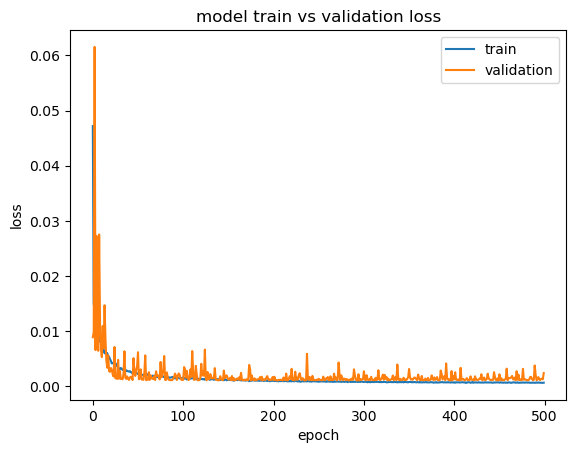

MAE after inverse scaling: 24.995450
RMSE after inverse scaling: 28.481231


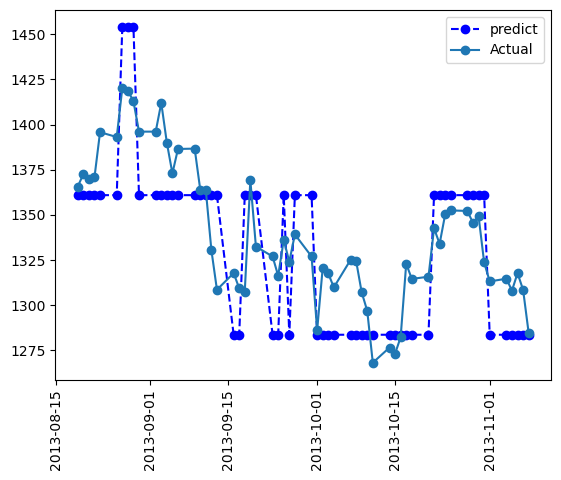

CPU times: user 7min 17s, sys: 52.2 s, total: 8min 9s
Wall time: 6min 39s


In [29]:
%%time
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

scaler = PowerTransformer()
data = Close.values
data = scaler.fit_transform(data)

y_scaler = PowerTransformer()
y_prime = Close.values[:,-1].reshape(-1, 1)
y_prime = y_scaler.fit_transform(y_prime)

# choose a number of time steps
n_steps = 4
# convert into input/output
X, y = split_sequences(data, n_steps)

#X_train, X_test =X[:-60], X[-60:]
#y_train, y_test =  y[:-60], y[-60:]

X_train, X_val, X_test = X[:-120,:] , X[-120:-60,:] , X[-60:,:]
y_train, y_val, y_test = y[:-120] ,y[-120:-60], y[-60:]
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model

model=Sequential()
model.add(GRU(128,return_sequences=True,input_shape=(n_steps,n_features)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))

"""model=Sequential()
model.add(GRU(32, activation='sigmoid',return_sequences=True,input_shape=(n_steps,n_features)))
model.add(GRU(32, activation='sigmoid',return_sequences=True))
model.add(GRU(32, activation='sigmoid'))
model.add(Dropout(0.20))
model.add(Dense(1))"""
#model.add(TimeDistributed(Dense(1))) #, activation= 'sigmoid' )))
#opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer='RMSprop', loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])

#es = EarlyStopping(monitor= 'val_loss' , min_delta=50)
# fit model
history = model.fit(X_train, y_train,validation_data=(X_val, y_val),
 epochs=500,batch_size=32, verbose=0)#,callbacks=[es])

model.summary()
# demonstrate prediction
test = []
for i in range(60):

    test.append(X_test[i])

yhat = model.predict(array(test), verbose=0)
prediction = []
for i in range(60):

    prediction.append(yhat[i][0])

mae = mean_absolute_error(y_test, prediction)
rmse = sqrt(mean_squared_error(y_test, prediction))
print('MAE before inverse Scaling: %f' % mae)
print('RMSE before inverse Scaling: %f' % rmse)

y_test = y_scaler.inverse_transform(y_test.reshape(-1, 1))
y_test = [ '%.1f' % y for y in y_test ]
y_test = [float(i) for i in y_test]
predict = y_scaler.inverse_transform(array(prediction).reshape(-1, 1))
predict = [ '%.3f' % y for y in predict ]
predict = [float(i) for i in predict]


plt.plot(history.history[ 'loss' ])
plt.plot(history.history[ 'val_loss' ])
plt.title( 'model train vs validation loss' )
plt.ylabel( 'loss' )
plt.xlabel( 'epoch' )
plt.legend([ 'train' , 'validation' ], loc= 'upper right' )
plt.show()

x = pd.DataFrame(Close.index[-60:]).values

mae = mean_absolute_error(y_test, predict)
rmse = sqrt(mean_squared_error(y_test, predict))
print('MAE after inverse scaling: %f' % mae)
print('RMSE after inverse scaling: %f' % rmse)

plt.plot(x, predict,'--bo', label = "predict",linestyle = 'dashed')
plt.plot(x, y_test,marker='o', label = "Actual")
plt.xticks(rotation = 90)
plt.legend()
plt.show()

#### 3


#### 4


Quellen:

* C6: https://www.kaggle.com/code/khashayarrahimi94/gold-price-forecasting-using-lstm-cnn-gru [Online, Stand: 12.01.2025]